# Análise de Concessão de Crédito
###Professor: Germano Vasconcelos


---


Alunos:
<br>
Felipe Jun Ting Lin - fjtl2@cin.ufpe.br
<br>
João Gabriel Vasconcelos - jgav@cin.ufpe.br
<br>
Maria Eduarda Mota - mebm@cin.ufpe.br
<br>
Rafael Bernardo Nunes Neto - rbnn@cin.ufpe.br

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install xlrd
%pip install torchsummary
%pip install optuna
%pip install scikit-plot
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from sklearn.datasets import make_blobs
from scipy.stats import ks_2samp
from tqdm import tqdm
import optuna
import scikitplot as skplt
import io
import os

## Análise e Preparação dos Dados

In [ ]:
df = pd.read_table('/content/drive/MyDrive/RedesNeurais/TRNcod.xls')
#df = pd.read_table('TRNcod.xls')
df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


Analisamos, a título de conhecimento, os valores não inteiros do banco de dados.

In [ ]:
# Definimos a função para chegar se o valor é inteiro
def is_integer(val):
    #if (val % 1 == 0):
    #    return True
    #else:
    #    return False
    return True if isinstance(val, int) else False

for column in df:
  integer_mask = df[column].apply(is_integer)
  # Checa se algum elemento da coluna é inteiro
  has_integers = integer_mask.any()

  # Printa o elemento não inteiro da coluna
  if not has_integers:
      print(f"A coluna {column} não possui valores inteiros.")
      print(f"Um exemplo de valor é {df[column][0]}.")

  # Printa se há elementos com valoração maiores que 10
  if max(df[column]) > 10:
    print(f"A coluna {column} possuí valor(es) maior(es) que 10.")

A coluna INDEX possuí valor(es) maior(es) que 10.
A coluna IDADE não possui valores inteiros.
Um exemplo de valor é 0.135097920813897.
A coluna NIVEL_RELACIONAMENTO_CREDITO01 não possui valores inteiros.
Um exemplo de valor é 0.222222222222222.
A coluna NIVEL_RELACIONAMENTO_CREDITO02 não possui valores inteiros.
Um exemplo de valor é 0.0.
A coluna ATIVIDADE_EMAIL não possui valores inteiros.
Um exemplo de valor é 5.88123507740785e-18.
A coluna EXPOSICAO_ENDERECO não possui valores inteiros.
Um exemplo de valor é 0.0416666666666667.
A coluna EXPOSICAO_EMAIL não possui valores inteiros.
Um exemplo de valor é 0.0.
A coluna EXPOSICAO_TELEFONE não possui valores inteiros.
Um exemplo de valor é 0.0.
A coluna ATIVIDADE_ENDERECO não possui valores inteiros.
Um exemplo de valor é 0.1055877023706.
A coluna ATUALIZACAO_ENDERECO não possui valores inteiros.
Um exemplo de valor é 0.796392205503436.
A coluna ATUALIZACAO_EMAIL não possui valores inteiros.
Um exemplo de valor é -5.14095849300494e-17.


Primeiramente, checamos por duplicatas no código.

In [ ]:
df[df.duplicated(keep=False)]

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2


In [ ]:
df.dtypes

INDEX          int64
UF_1           int64
UF_2           int64
UF_3           int64
UF_4           int64
               ...  
CEP4_12        int64
CEP4_13        int64
CEP4_14        int64
IND_BOM_1_1    int64
IND_BOM_1_2    int64
Length: 246, dtype: object

In [ ]:
df.describe()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
count,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,3.891960e+05,389196.000000,...,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000,389196.000000
mean,194597.500000,0.889274,0.691952,0.476552,0.296195,0.241179,0.218011,0.186836,4.552049e-01,0.521514,...,0.423378,0.417540,0.425708,0.459820,0.440842,0.436896,0.433709,0.440339,0.655449,0.344551
std,112351.352021,0.313793,0.461687,0.499451,0.456579,0.427799,0.412895,0.389781,2.537459e-01,0.499538,...,0.494095,0.493154,0.494451,0.498384,0.496489,0.496002,0.495587,0.496428,0.475222,0.475222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.506237e-16,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,97298.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.507866e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,194597.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.375241e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,291896.250000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.578835e-01,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,389195.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Como os parâmetros 'IND_BOM_1_1' e 'IND_BOM_1_2' são indicadores do mesmo dado, podemos trabalhar apenas com um deles. Para a nossa análise, escolhemos 'IND_BOM_1_2'.

In [ ]:
df['IND_BOM_1_1'].value_counts()

1    255098
0    134098
Name: IND_BOM_1_1, dtype: int64

In [ ]:
df['IND_BOM_1_2'].value_counts()

0    255098
1    134098
Name: IND_BOM_1_2, dtype: int64

In [ ]:
# Vemos aqui que não possuímos 'IND_BOM_1_1' e 'IND_BOM_1_2' com valores iguais para uma mesma instância
df.loc[((df['IND_BOM_1_1'] == 0) & ( df['IND_BOM_1_2'] == 0)) | ((df['IND_BOM_1_1'] == 1) & ( df['IND_BOM_1_2'] == 1))].count()[0]

0

Como podemos ver no plot a seguir, há uma distribuição desigual das instâncias no referente ao parâmetro de concessão de crédito.

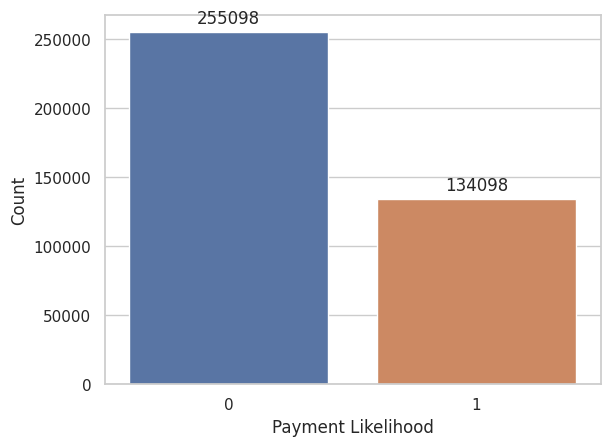

In [ ]:
sns.set_theme(style="whitegrid")
title="Penguin species exhibit distinct bill shapes"
ax = sns.countplot(data=df, x='IND_BOM_1_2')
ax.set(xlabel='Payment Likelihood', ylabel='Count')
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

Fazemos uma separação das instâncias com valor do parâmetro analisado.

In [ ]:
dfMinor = df[df['IND_BOM_1_2']==1]
dfMajor = df[df['IND_BOM_1_2']==0]

### Set de Treino e Validação

Separamos os dados em set treino e validação em uma proporação de 70% para 30%, respectivamente (segmentando o target 'IND_BOM_1_2' e removendo o parâmetro 'IND_BOM_1_1' que é redundante). Como pretendemos fazer uma mistura dos dados Major e Minor, posteriormente, mantemos o target label no dataset X.

In [ ]:
data_train_minor, data_val_minor, _, _ = train_test_split(dfMinor, dfMinor['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [ ]:
print(data_train_minor.shape)

(89845, 246)


In [ ]:
print(data_val_minor.shape)

(44253, 246)


In [ ]:
data_train_major, data_val_major, _, _ = train_test_split(dfMajor, dfMajor['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [ ]:
print(data_train_major.shape)

(170915, 246)


In [ ]:
print(data_val_major.shape)

(84183, 246)


### Oversampling

Visto que possuímos uma distribuição desigual de dados por classe, fazemos uma repopulação de instâncias de treino X_train_major até que a quantidade seja equivalente a X_train_minor (Fazemos uma concatenação simples).

In [ ]:
difference_train = data_train_major.shape[0] - data_train_minor.shape[0]
difference_train

81070

In [ ]:
data_train_minor_sampled = pd.concat([data_train_minor, data_train_minor[:difference_train]])

In [ ]:
data_train_minor_sampled.shape

(170915, 246)

In [ ]:
data_train_minor_sampled.shape == data_train_major.shape

True

In [ ]:
difference_val = data_val_major.shape[0] - data_val_minor.shape[0]
difference_val

39930

In [ ]:
data_val_minor_sampled = pd.concat([data_val_minor, data_val_minor[:difference_val]])

In [ ]:
data_val_minor_sampled.shape

(84183, 246)

In [ ]:
data_val_minor_sampled.shape == data_val_major.shape

True

### Concatenação e Randomização dos Dados

In [ ]:
data_train = pd.concat([data_train_minor_sampled, data_train_major]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data_train.shape

(341830, 246)

In [ ]:
data_train.head(5)

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,288589,1,1,0,0,0,0,1,1.000000,0,...,0,0,0,1,1,1,0,1,1,0
1,191828,1,1,0,0,0,1,0,0.816508,0,...,0,0,0,1,1,0,0,0,1,0
2,364983,1,0,0,1,0,0,1,0.438603,0,...,0,0,0,1,0,1,0,1,0,1
3,200911,1,1,1,0,0,0,0,0.578145,1,...,0,0,1,0,1,1,0,0,0,1
4,151300,1,1,0,0,1,0,0,0.639880,1,...,0,1,1,0,0,0,0,1,0,1


In [ ]:
data_val = pd.concat([data_val_minor_sampled, data_val_major]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
data_val.shape

(168366, 246)

In [ ]:
data_val.head(5)

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,241985,1,0,0,1,1,0,0,0.469215,1,...,0,1,1,0,0,1,0,1,1,0
1,133371,1,0,0,1,1,0,0,0.220175,0,...,1,1,1,0,0,0,0,0,1,0
2,188775,1,1,1,0,0,0,0,0.682134,1,...,0,1,0,1,1,1,0,0,0,1
3,67904,1,1,1,0,0,0,0,0.118401,0,...,0,0,0,1,1,0,1,0,0,1
4,69261,1,1,0,1,0,0,0,0.627045,1,...,1,1,0,0,0,0,1,0,1,0


In [ ]:
# Dropping the Index column
data_train = data_train.drop(columns=["INDEX", "IND_BOM_1_1"])
data_val = data_val.drop(columns=["INDEX", "IND_BOM_1_1"])

<Axes: xlabel='IND_BOM_1_2', ylabel='count'>

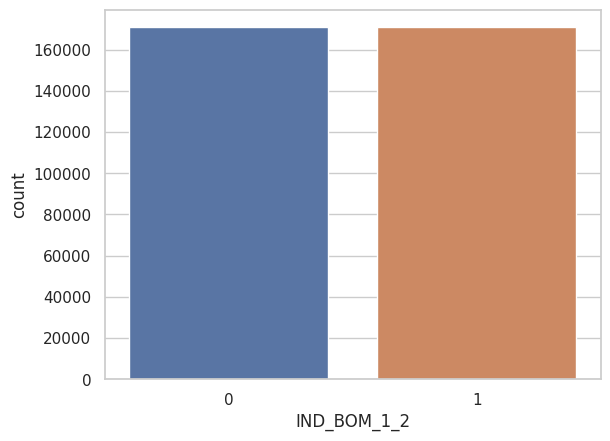

In [ ]:
sns.countplot(x=data_train['IND_BOM_1_2'])

<Axes: xlabel='IND_BOM_1_2', ylabel='count'>

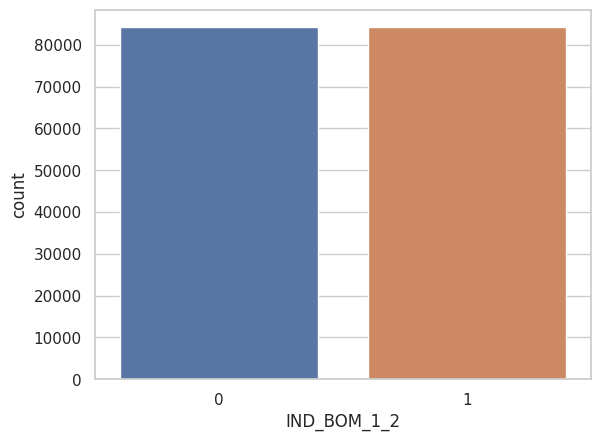

In [ ]:
sns.countplot(x=data_val['IND_BOM_1_2'])

Possuimos, agora, dados balanceados tanto no treino quanto na validação.

### Normalização dos Dados

In [ ]:
def scaler(data):
  return (data - data.min())/(data.max() - data.min())

In [ ]:
def inverse_scaler(scaled_data, original_data):
  return scaled_data * (original_data.max() - original_data.min()) + original_data.min()

In [ ]:
normalized_train=scaler(data_train)
normalized_val=scaler(data_val)

In [ ]:
# Check for negtive values
(normalized_train >= 0).all().any() and (normalized_val >= 0).all().any()

True

Trabalhamos com nossos dados base em numpy.

In [ ]:
train_numpy = normalized_train.to_numpy()
val_numpy = normalized_val.to_numpy()
print(f'Our train data has shape: {train_numpy.shape}. Our validation data has shape: {val_numpy.shape}')

Our train data has shape: (341830, 244). Our validation data has shape: (168366, 244)


#### Funções Auxiliares

In [ ]:
# Mean Squared Error
def mean_squared_error(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [ ]:
# Função de Plot
#def model_evaluation(history, model, scaler, X_test, X_train, y_train, y_test):
def model_evaluation(history):
  figure = plt.figure(figsize=(5,3))

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'upper left')
  plt.show()
"""
  y_hat = model.predict(X_test)
  y_t = model.predict(X_train)

  y_test_inverse = inverse_scaler(y_test)
  y_hat_inverse = inverse_scaler(y_hat)

  plt.plot(y_test_inverse, label='Actual Price', color = 'green')
  plt.plot(y_hat_inverse, label='Predicted Price', color = 'red')

  plt.title('Bitcoin price prediction')
  plt.xlabel('Time [days]')
  plt.ylabel('Price')
  plt.legend(['Actual Price', 'Predicted Price'], loc = 'upper right')
  ## adicionar legenda com os parametros atuais

  trainScore = math.sqrt(mean_squared_error(y_val[0], y_t[0]))
  print('Train Score: %.4f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test[0], y_hat[0]))
  print('Test Score: %.4f RMSE' % (testScore))

  plt.show()
"""

"\n  y_hat = model.predict(X_test)\n  y_t = model.predict(X_train)\n\n  y_test_inverse = inverse_scaler(y_test)\n  y_hat_inverse = inverse_scaler(y_hat)\n \n  plt.plot(y_test_inverse, label='Actual Price', color = 'green')\n  plt.plot(y_hat_inverse, label='Predicted Price', color = 'red')\n\n  plt.title('Bitcoin price prediction')\n  plt.xlabel('Time [days]')\n  plt.ylabel('Price')\n  plt.legend(['Actual Price', 'Predicted Price'], loc = 'upper right')\n  ## adicionar legenda com os parametros atuais\n\n  trainScore = math.sqrt(mean_squared_error(y_val[0], y_t[0]))\n  print('Train Score: %.4f RMSE' % (trainScore))\n  testScore = math.sqrt(mean_squared_error(y_test[0], y_hat[0]))\n  print('Test Score: %.4f RMSE' % (testScore))\n\n  plt.show()\n"

## Aux plot function

In [ ]:
def ks_results(y_true, y_pred):
  return ks_2samp(y_pred[y_true == 1], y_pred[y_true != 1]).statistic

In [ ]:
def reshape_plot(y_hat, y_true):
  print(f'type of y_hat: {type(y_hat)}, type of y_true: {type(y_true)}')
  if not isinstance(y_hat, np.ndarray):
    y_hat = y_hat.to_numpy(dtype=np.float32)
  if not isinstance(y_true, np.ndarray):
    y_true = y_true.to_numpy(dtype=np.float32)

  return y_hat.round().reshape(-1,1), y_true.reshape(-1,1)

In [ ]:
def historyPlot(model, history_dict, x, y, isMLP = False):
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  accuracy = history_dict['accuracy']
  val_accuracy = history_dict['accuracy']

  epochs = range(1, len(loss_values) + 1)
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  ax[0].set_title('Training & Validation Accuracy', fontsize=16)
  ax[0].set_xlabel('Epochs', fontsize=16)
  ax[0].set_ylabel('Accuracy', fontsize=16)
  ax[0].legend()

  ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
  ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
  ax[1].set_title('Training & Validation Loss', fontsize=16)
  ax[1].set_xlabel('Epochs', fontsize=16)
  ax[1].set_ylabel('Loss', fontsize=16)
  ax[1].legend()

  testePlot(model, x, y, isMLP)

In [ ]:
def testePlot(model, x, y, isMLP = False, isSVC = False):
  y_pred = model.predict(x)
  y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])
  if isMLP:
    y_pred_score = model.predict(x)
    print(y_pred_score)
    y_pred_score_0 = 1 - y_pred_score
    y_pred_score = np.concatenate([y_pred_score_0, y_pred_score], axis = 1)
  elif isSVC:
    y_pred_score = model.predict(x)
    y_pred_score = np.reshape(y_pred_score, (len(y_pred_score), 1))
    y_pred_score_0 = 1 - y_pred_score
    y_pred_score = np.concatenate([y_pred_score_0, y_pred_score], axis = 1)
  else:
    y_pred_score = model.predict_proba(x)
  accuracy = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred)
  precision = precision_score(y, y_pred)
  f1 = f1_score(y, y_pred)


  skplt.metrics.plot_ks_statistic(y, y_pred_score)
  plt.show()
  y_pred_score = y_pred_score[:, 1]
  a1, a2 = reshape_plot(y_pred, y)
  print(f'a1 shape: {a1.shape} a1 type: {type(a1)} a2 shape: {a2.shape} a2 type: {type(a2)}')
  ks = ks_results(a1, a2)
  auroc = roc_auc_score(y, y_pred_score)
  aupr = average_precision_score(y, y_pred_score)

  cm = confusion_matrix(y, y_pred, labels = np.unique(y_val))
  cmd = ConfusionMatrixDisplay(cm, display_labels = np.unique(y_val))
  cmd.plot()
  plt.show()

  print()
  if isMLP:
    print("{metric:<18}{value}".format(metric="Score:", value=model.evaluate(x, y)))
  print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
  print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
  print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
  print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
  if auroc is not None:
      print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
  if aupr is not None:
      print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))
  print("{metric:<18}{value:.4f}".format(metric="KS:", value=ks))

### MLP Keras / Tensor-Flow Approach


#### Raw Approach

In [ ]:
X_train = train_numpy[:,:-1]
y_train = train_numpy[:,-1].reshape(train_numpy.shape[0],1)

In [ ]:
X_val = val_numpy[:,:-1]
y_val = val_numpy[:,-1].reshape(val_numpy.shape[0],1)

Teste de Amostra com Kolmogorov-Smirnov:

In [ ]:
ks_2samp(X_train[-1], X_val[-1])

KstestResult(statistic=0.08641975308641975, pvalue=0.32484043142517294, statistic_location=0.047384860811258, statistic_sign=-1)

#### Definindo uma MLP básica

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_MLP = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
10683/10683 [==============================] - 15s 1ms/step - loss: 0.6432 - accuracy: 0.6290 - val_loss: 0.6352 - val_accuracy: 0.6383
Epoch 2/10
10683/10683 [==============================] - 14s 1ms/step - loss: 0.6339 - accuracy: 0.6389 - val_loss: 0.6372 - val_accuracy: 0.6368
Epoch 3/10
10683/10683 [==============================] - 14s 1ms/step - loss: 0.6304 - accuracy: 0.6424 - val_loss: 0.6346 - val_accuracy: 0.6389
Epoch 4/10
10683/10683 [==============================] - 14s 1ms/step - loss: 0.6276 - accuracy: 0.6463 - val_loss: 0.6341 - val_accuracy: 0.6409
Epoch 5/10
10683/10683 [==============================] - 14s 1ms/step - loss: 0.6249 - accuracy: 0.6481 - val_loss: 0.6344 - val_accuracy: 0.6386
Epoch 6/10
10683/10683 [==============================] - 14s 1ms/step - loss: 0.6220 - accuracy: 0.6513 - val_loss: 0.6339 - val_accuracy: 0.6398
Epoch 7/10
10683/10683 [==============================] - 15s 1ms/step - loss: 0.6193 - accuracy: 0.6543 - val_loss: 0

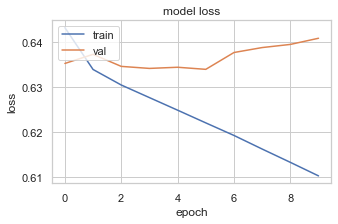

In [ ]:
model_evaluation(history_MLP)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_val, y_val)

5262/5262 [==============================] - 4s 820us/step - loss: 0.6408 - accuracy: 0.6370


In [ ]:
# Print the evaluation results
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.6408007740974426
Test Accuracy: 0.6369932293891907


In [ ]:
def objective(trial):
    n_units = trial.suggest_categorical('n_units', [16, 32, 64, 128, 256, 512, 1024])
    dropout = trial.suggest_float('dropout', 0.0, 0.5, step=0.1, log=False)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 0.00005, 0.1, step=0.01, log=False)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 10, 15)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n_units, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation=activation))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

    print('Val_loss: %.3f, Val_acc: %.3f' % (val_loss, val_acc))

    return val_acc

In [ ]:
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=1)

[I 2023-04-26 09:54:47,764] A new study created in memory with name: no-name-c2449316-487f-448e-bd50-c0f1f13a7f5d
c:\Users\Felipe_Lin\anaconda3\lib\site-packages\optuna\distributions.py:701: UserWarning: The distribution is specified by [5e-05, 0.1] and step=0.01, but the range is not divisible by `step`. It will be replaced by [5e-05, 0.09005].
  warnings.warn(


Epoch 1/14
2671/2671 [==============================] - 43s 16ms/step - loss: 5.0838 - accuracy: 0.5003 - val_loss: 5.6255 - val_accuracy: 0.5000
Epoch 2/14
2671/2671 [==============================] - 44s 17ms/step - loss: 5.0500 - accuracy: 0.4995 - val_loss: 7.5176 - val_accuracy: 0.5000
Epoch 3/14
2671/2671 [==============================] - 41s 15ms/step - loss: 5.0434 - accuracy: 0.5001 - val_loss: 6.8947 - val_accuracy: 0.5000
Epoch 4/14
2671/2671 [==============================] - 34s 13ms/step - loss: 5.0326 - accuracy: 0.5010 - val_loss: 5.8917 - val_accuracy: 0.5000
Epoch 5/14
2671/2671 [==============================] - 37s 14ms/step - loss: 5.0457 - accuracy: 0.4996 - val_loss: 4.5859 - val_accuracy: 0.5000
Epoch 6/14
2671/2671 [==============================] - 37s 14ms/step - loss: 5.0275 - accuracy: 0.4997 - val_loss: 4.8083 - val_accuracy: 0.5000
Epoch 7/14
2671/2671 [==============================] - 36s 13ms/step - loss: 5.0401 - accuracy: 0.4995 - val_loss: 7.0208 -

[I 2023-04-26 10:03:42,921] Trial 0 finished with value: 0.5 and parameters: {'n_units': 1024, 'dropout': 0.30000000000000004, 'optimizer': 'rmsprop', 'learning_rate': 0.050050000000000004, 'batch_size': 128, 'epochs': 14, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.5.


Val_loss: 5.705, Val_acc: 0.500


In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 1
Best trial: {'n_units': 1024, 'dropout': 0.30000000000000004, 'optimizer': 'rmsprop', 'learning_rate': 0.050050000000000004, 'batch_size': 128, 'epochs': 14, 'activation': 'sigmoid'}


In [ ]:
best_mlp = study.best_trial.params
best_mlp

{'n_units': 1024,
 'dropout': 0.30000000000000004,
 'optimizer': 'rmsprop',
 'learning_rate': 0.050050000000000004,
 'batch_size': 128,
 'epochs': 14,
 'activation': 'sigmoid'}

In [ ]:
mlp_opt = Sequential()
mlp_opt.add(Dense(units=best_mlp['n_units'], input_dim=X_train.shape[1], activation=best_mlp['activation']))
mlp_opt.add(Dropout(best_mlp['dropout']))
mlp_opt.add(Dense(units=best_mlp['n_units'], activation=best_mlp['activation']))
mlp_opt.add(Dropout(best_mlp['dropout']))
mlp_opt.add(Dense(1, activation=best_mlp['activation']))

mlp_opt.compile(loss='binary_crossentropy', optimizer=best_mlp['optimizer'], metrics=['accuracy'])

history_mlp_opt = mlp_opt.fit(X_train, y_train, epochs=best_mlp['epochs'], batch_size=best_mlp['batch_size'], validation_data=(X_val, y_val))

Epoch 1/14
2671/2671 [==============================] - 36s 13ms/step - loss: 0.6744 - accuracy: 0.5962 - val_loss: 0.6470 - val_accuracy: 0.6256
Epoch 2/14
2671/2671 [==============================] - 35s 13ms/step - loss: 0.6489 - accuracy: 0.6227 - val_loss: 0.6428 - val_accuracy: 0.6285
Epoch 3/14
2671/2671 [==============================] - 36s 14ms/step - loss: 0.6459 - accuracy: 0.6251 - val_loss: 0.6433 - val_accuracy: 0.6290
Epoch 4/14
2671/2671 [==============================] - 38s 14ms/step - loss: 0.6443 - accuracy: 0.6273 - val_loss: 0.6527 - val_accuracy: 0.6208
Epoch 5/14
2671/2671 [==============================] - 39s 14ms/step - loss: 0.6432 - accuracy: 0.6281 - val_loss: 0.6496 - val_accuracy: 0.6235
Epoch 6/14
2671/2671 [==============================] - 37s 14ms/step - loss: 0.6416 - accuracy: 0.6297 - val_loss: 0.6375 - val_accuracy: 0.6349
Epoch 7/14
2671/2671 [==============================] - 38s 14ms/step - loss: 0.6395 - accuracy: 0.6323 - val_loss: 0.6363 -

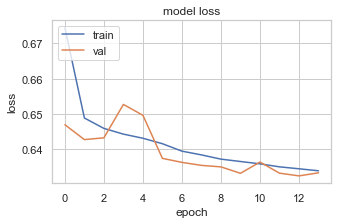

In [ ]:
model_evaluation(history_mlp_opt)

In [ ]:
loss, accuracy = mlp_opt.evaluate(X_val, y_val)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

5262/5262 [==============================] - 10s 2ms/step - loss: 0.6334 - accuracy: 0.6390
Test Loss: 0.6334037780761719
Test Accuracy: 0.6389710307121277


In [ ]:
y_pred = mlp_opt.predict(X_val)

5262/5262 [==============================] - 10s 2ms/step


In [ ]:
y_pred.round()

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
y_pred.shape

(168366, 1)

In [ ]:
y_val.shape

(168366, 1)

In [ ]:
ks = ks_2samp(y_pred[y_val == 1], y_pred[y_val != 1])
ks

KstestResult(statistic=0.28068612427687295, pvalue=0.0)

5262/5262 [==============================] - 9s 2ms/step
[[0.31577155]
 [0.5619957 ]
 [0.65756136]
 ...
 [0.69955105]
 [0.7104842 ]
 [0.70483845]]


c:\Users\Felipe_Lin\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


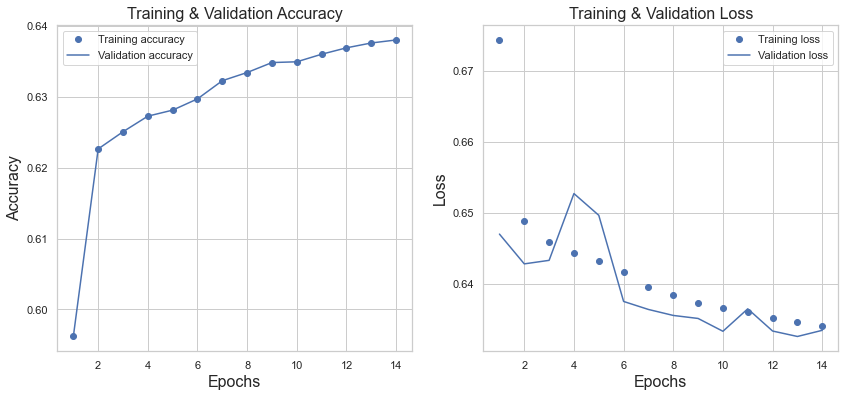

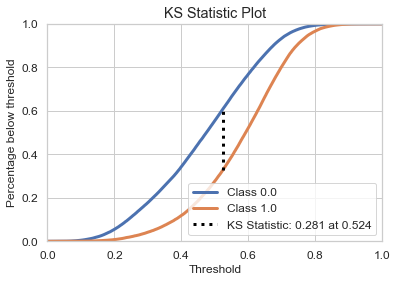

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
a1 shape: (168366, 1) a1 type: <class 'numpy.ndarray'> a2 shape: (168366, 1) a2 type: <class 'numpy.ndarray'>


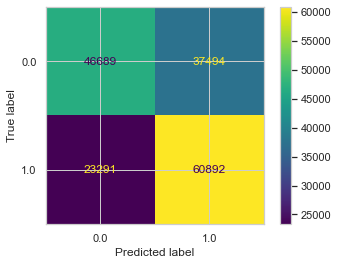


5262/5262 [==============================] - 9s 2ms/step - loss: 0.6334 - accuracy: 0.6390
Score:            [0.6334037780761719, 0.6389710307121277]
Accuracy:         0.6390
Recall:           0.7233
Precision:        0.6189
F1:               0.6671
AUROC:            0.6935
AUPR:             0.6729
KS:               0.2861


In [ ]:
historyPlot(mlp_opt, history_mlp_opt.history, X_val, y_val, True)

<AxesSubplot:>

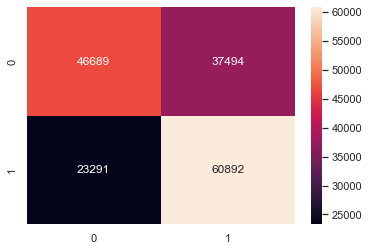

In [ ]:
sns.heatmap(confusion_matrix(y_val, y_pred.round()), annot=True, fmt='g')

## Definindo Random Forest básico

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

for _ in tqdm(range(1)):
    rf.fit(X_train, y_train.ravel())

y_pred = rf.predict(X_val)


100%|██████████| 1/1 [00:48<00:00, 48.85s/it]


In [ ]:
def sns_heatmap(y_train, y_pred):
    sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='g')

In [ ]:
def sk_model_evaluation(model_name=rf, y_val=y_val, y_pred=y_pred):
    print('The model used is {}'.format(model_name))
    print('Accuracy Score:', accuracy_score(y_val, y_pred))
    print('Precision Score:', precision_score(y_val, y_pred))
    print('Recall Score:', recall_score(y_val, y_pred))
    print('F1 Score:', f1_score(y_val, y_pred))
    print('ROC AUC Score:', roc_auc_score(y_val, y_pred))
    print('SK score:', ks_results(reshape_plot(y_val, y_pred)[0], reshape_plot(y_val, y_pred)[1]))
    print('Classification Report:\n', classification_report(y_val, y_pred))
    print('Confusion Matrix:\n', sns_heatmap(y_val, y_pred))
    plt.show()

The model used is RandomForestClassifier(n_jobs=-1, random_state=42)
Accuracy Score: 0.6513013316227741
Precision Score: 0.6387412313188968
Recall Score: 0.6965658149507621
F1 Score: 0.6664014955650134
ROC AUC Score: 0.6513013316227743
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
SK score: 0.30260266324554835
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.61      0.63     84183
         1.0       0.64      0.70      0.67     84183

    accuracy                           0.65    168366
   macro avg       0.65      0.65      0.65    168366
weighted avg       0.65      0.65      0.65    168366

Confusion Matrix:
 None


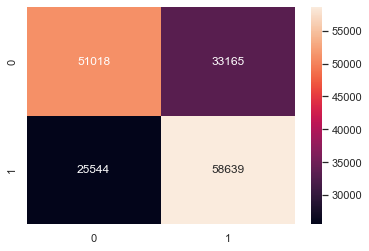

In [ ]:
sk_model_evaluation(rf, y_val, y_pred)


In [ ]:
ks = ks_results(reshape_plot(y_val, y_pred)[0], reshape_plot(y_val, y_pred)[1])
roc = roc_auc_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


In [ ]:
results_basic = pd.DataFrame({'model': 'Random Forest Básico', 'ks': ks, 'roc': roc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}, index=[0])
results_basic

,model,ks,roc,accuracy,precision,recall,f1
0,Random Forest Básico,0.302603,0.651301,0.651301,0.638741,0.696566,0.666401


In [ ]:
rf_params = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 10],
    'min_samples_split': [2, 8, 10],
    'min_samples_leaf': [4, 6, 10],
    'max_features': ['sqrt', 'log2', None],
}

In [ ]:
# use optuna to find the best parameters described above using roc_auc and ks as metrics

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 10, step=2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 10, step=2)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1, verbose=3)

    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_val)

    ks = ks_results(reshape_plot(y_pred, y_val)[0], reshape_plot(y_pred, y_val)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

In [ ]:
study = optuna.create_study(direction='maximize')

study.optimize(objective_rf, n_trials=1)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-26 11:11:46,119] A new study created in memory with name: no-name-09ed3573-b054-475c-9308-c96379fa4ae3
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100building tree 10 of 100building tree 11 of 100
building tree 12 of 100


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.7s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished


type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


[I 2023-04-26 11:12:38,710] Trial 0 finished with value: 0.24256119495135625 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.24256119495135625.


Number of finished trials: 1
Best trial: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


In [ ]:
study.trials

ks = [trial.user_attrs['ks'] for trial in study.trials]
roc_auc = [trial.user_attrs['roc_auc'] for trial in study.trials]
accuracy = [trial.user_attrs['accuracy'] for trial in study.trials]
precision = [trial.user_attrs['precision'] for trial in study.trials]
recall = [trial.user_attrs['recall'] for trial in study.trials]
f1 = [trial.user_attrs['f1'] for trial in study.trials]

results = pd.DataFrame({'model': 'Random Forest Optuna','ks': ks, 'roc_auc': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
results

,model,ks,roc_auc,accuracy,precision,recall,f1
0,Random Forest Optuna,0.242561,0.606732,0.606732,0.663286,0.433555,0.524363


In [ ]:
best_rf = study.best_trial.params
best_rf

{'n_estimators': 100,
 'criterion': 'gini',
 'max_depth': 2,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt'}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.8s finished
c:\Users\Felipe_Lin\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


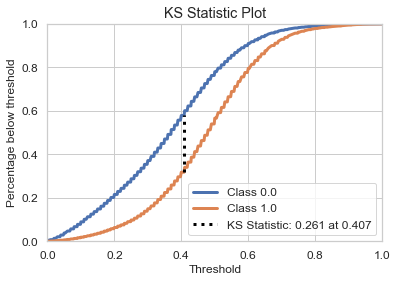

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
a1 shape: (168366, 1) a1 type: <class 'numpy.ndarray'> a2 shape: (168366, 1) a2 type: <class 'numpy.ndarray'>


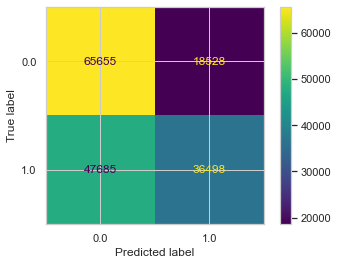


Accuracy:         0.6067
Recall:           0.4336
Precision:        0.6633
F1:               0.5244
AUROC:            0.6750
AUPR:             0.6390
KS:               0.2426


In [ ]:
rf_opt = RandomForestClassifier(n_estimators=best_rf['n_estimators'],random_state=42, n_jobs=-1, verbose=3)

rf_opt.fit(X_train, y_train.ravel())

testePlot(rf_opt, X_val, y_val)

In [ ]:
gb = GradientBoostingClassifier(random_state=42, verbose=4)

gb.fit(X_train, y_train.ravel())

y_pred = gb.predict(X_val)

      Iter       Train Loss   Remaining Time 
         1           1.3742           14.57m
         2           1.3643           14.23m
         3           1.3558           14.26m
         4           1.3488           13.96m
         5           1.3421           13.63m
         6           1.3367           13.45m
         7           1.3316           13.34m
         8           1.3267           13.22m
         9           1.3224           13.04m
        10           1.3190           12.86m
        11           1.3158           12.74m
        12           1.3129           12.60m
        13           1.3093           12.45m
        14           1.3069           12.29m
        15           1.3047           12.13m
        16           1.3027           12.01m
        17           1.2994           11.85m
        18           1.2967           11.69m
        19           1.2943           11.53m
        20           1.2928           11.35m
        21           1.2914           11.17m
        2

The model used is GradientBoostingClassifier(random_state=42, verbose=4)
Accuracy Score: 0.6513013316227741
Precision Score: 0.6387412313188968
Recall Score: 0.6965658149507621
F1 Score: 0.6664014955650134
ROC AUC Score: 0.6513013316227743
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
SK score: 0.30260266324554835
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.61      0.63     84183
         1.0       0.64      0.70      0.67     84183

    accuracy                           0.65    168366
   macro avg       0.65      0.65      0.65    168366
weighted avg       0.65      0.65      0.65    168366

Confusion Matrix:
 None


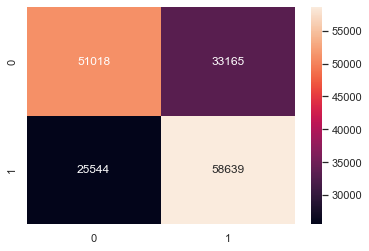

In [ ]:
sk_model_evaluation(gb, y_val, y_pred)

In [ ]:
ks = ks_results(reshape_plot(y_val, y_pred)[0], reshape_plot(y_val, y_pred)[1])
roc = roc_auc_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

results_basic.loc[1] = ['Gradient Boosting Básico', ks, roc, accuracy, precision, recall, f1]
results_basic

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>


,model,ks,roc,accuracy,precision,recall,f1
0,Random Forest Básico,0.302603,0.651301,0.651301,0.638741,0.696566,0.666401
1,Gradient Boosting Básico,0.302603,0.651301,0.651301,0.638741,0.696566,0.666401


In [ ]:
def objective_gb(trial):
    loss = trial.suggest_categorical('loss', ['log_loss', 'deviance', 'exponential'])
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)

    model = GradientBoostingClassifier(loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, random_state=42, verbose=3)

    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_val)

    ks = ks_results(reshape_plot(y_pred, y_val)[0], reshape_plot(y_pred, y_val)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

In [ ]:
study_gb = optuna.create_study(direction='maximize')
study_gb.optimize(objective_gb, n_trials=1)

[I 2023-04-26 12:02:01,737] A new study created in memory with name: no-name-cb599701-598c-425a-8f6f-2307761ff5fe
C:\Users\Felipe_Lin\AppData\Local\Temp\ipykernel_10692\3535606896.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)


      Iter       Train Loss   Remaining Time 
         1           0.9986           15.40m
         2           0.9972           14.67m
         3           0.9959           14.20m
         4           0.9946           13.96m
         5           0.9934           13.70m
         6           0.9922           13.49m
         7           0.9911           13.31m
         8           0.9900           13.16m
         9           0.9889           13.01m
        10           0.9879           12.85m
        11           0.9869           12.71m
        12           0.9860           12.57m
        13           0.9851           12.42m
        14           0.9842           12.28m
        15           0.9833           12.14m
        16           0.9824           11.98m
        17           0.9816           11.84m
        18           0.9809           11.70m
        19           0.9801           11.54m
        20           0.9794           11.39m
        21           0.9786           11.23m
        2

[I 2023-04-26 12:15:59,213] Trial 0 finished with value: 0.27887679366684937 and parameters: {'loss': 'exponential', 'learning_rate': 0.02279859731493836, 'n_estimators': 100}. Best is trial 0 with value: 0.27887679366684937.


In [ ]:
study_gb.trials

ks = [trial.user_attrs['ks'] for trial in study_gb.trials]
roc_auc = [trial.user_attrs['roc_auc'] for trial in study_gb.trials]
accuracy = [trial.user_attrs['accuracy'] for trial in study_gb.trials]
precision = [trial.user_attrs['precision'] for trial in study_gb.trials]
recall = [trial.user_attrs['recall'] for trial in study_gb.trials]
f1 = [trial.user_attrs['f1'] for trial in study_gb.trials]

results.loc[1] = ['Gradient Boosting Optuna', ks[0], roc_auc[0], accuracy[0], precision[0], recall[0], f1[0]]
results

,model,ks,roc_auc,accuracy,precision,recall,f1
0,Random Forest Optuna,0.242561,0.606732,0.606732,0.663286,0.433555,0.524363
1,Gradient Boosting Optuna,0.278877,0.634410,0.634410,0.612958,0.729363,0.666113


In [ ]:
best_gb = study_gb.best_trial.params
best_gb

{'loss': 'exponential',
 'learning_rate': 0.02279859731493836,
 'n_estimators': 100}

      Iter       Train Loss   Remaining Time 
         1           0.9986           13.78m
         2           0.9972           13.49m
         3           0.9959           13.55m
         4           0.9946           13.49m
         5           0.9934           13.47m
         6           0.9922           13.35m
         7           0.9911           13.17m
         8           0.9900           13.00m
         9           0.9889           12.84m
        10           0.9879           12.66m
        11           0.9869           12.51m
        12           0.9860           12.33m
        13           0.9851           12.17m
        14           0.9842           12.02m
        15           0.9833           11.87m
        16           0.9824           11.71m
        17           0.9816           11.56m
        18           0.9809           11.40m
        19           0.9801           11.35m
        20           0.9794           11.31m
        21           0.9786           11.32m
        2

c:\Users\Felipe_Lin\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


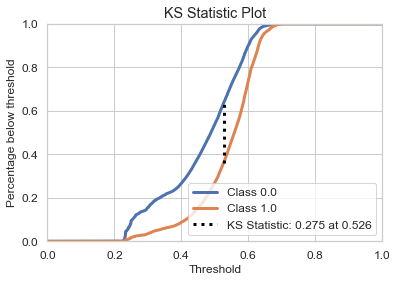

type of y_hat: <class 'numpy.ndarray'>, type of y_true: <class 'numpy.ndarray'>
a1 shape: (168366, 1) a1 type: <class 'numpy.ndarray'> a2 shape: (168366, 1) a2 type: <class 'numpy.ndarray'>


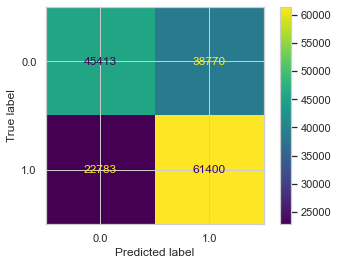


Accuracy:         0.6344
Recall:           0.7294
Precision:        0.6130
F1:               0.6661
AUROC:            0.6889
AUPR:             0.6689
KS:               0.2789


In [ ]:
gb_opt = GradientBoostingClassifier(loss=best_gb['loss'], learning_rate=best_gb['learning_rate'], n_estimators=best_gb['n_estimators'], random_state=42, verbose=3)

gb_opt.fit(X_train, y_train.ravel())

testePlot(gb_opt, X_val, y_val)

### Abordagem em Redes Neurais (Pytorch - Legacy)


Primeiramente, preparamos os dados e os separamos em $'features'$ e $'target'$.

In [ ]:
class CreditDataset(Dataset):
  def __init__(self, data):
    #self.X = torch.from_numpy(data[:,:-2])
    self.X = torch.tensor(data[:,1:-2], dtype=torch.float)
    #self.y = torch.from_numpy(data[:,-1])
    y = torch.tensor(data[:,-1], dtype=torch.float)
    self.y = y.view([-1,1])
    self.n_samples = data.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.n_samples

In [ ]:
train_tensor = CreditDataset(train_numpy)

In [ ]:
val_tensor = CreditDataset(val_numpy)

In [ ]:
batch_size=16

In [ ]:
train_loader = DataLoader(dataset=train_tensor,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
val_loader = DataLoader(dataset=val_tensor,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0)

In [ ]:
# Number of batches must be the total of samples divided by the batch size
print(len(train_loader))
print(math.ceil(train_numpy.shape[0]/batch_size))

21365
21365


Fazemos a análise de um dos dados, para exemplificar (Temos).

In [ ]:
train_iter = iter(train_loader)
train_example = next(train_iter)
features, target = train_example
print(features.shape)
print(target.shape)

torch.Size([16, 241])
torch.Size([16, 1])


Agora que os nossos dados estão prontos, podemos configurar a rede.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Network(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size,hidden_size)
    self.fc3 = nn.Linear(hidden_size,output_size)
    self.leaky = nn.LeakyReLU(0.1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    out = self.relu(self.fc1(input))
    out = self.leaky(self.fc2(out))
    out = self.relu(self.fc3(out))
    out = self.sigmoid(out)

    return out

Definimos os hiperparâmetros da nossa rede.


In [ ]:
print(train_tensor.X.shape)
print(train_tensor.y.shape)

torch.Size([341830, 241])
torch.Size([341830, 1])


In [ ]:
num_epochs = 1
input_size = train_tensor.X.shape[1]
output_size = 1
hidden_size = 256
learning_rate = 0.00001

In [ ]:
model = Network(input_size, hidden_size, output_size)

In [ ]:
#summary(model, input_size=(train_tensor.X.shape[0], train_tensor.X.shape[1]), batch_size=64)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):

  train_correct = 0
  model.train()
  train_loss = 0

  for batch_idx, (features, targets) in enumerate(train_loader):
    # Clear gradients
    optimizer.zero_grad()
    # Obtain logits
    outputs = model(features)
    # Calculate loss
    loss = criterion(outputs, targets)
    # Backward
    loss.backward()
    # Gradient Descent
    optimizer.step()

    train_loss += loss.item() * features.shape[0]

    train_predicted = torch.round(outputs)
    #if(len(predicted) == len(targets)):
    train_correct += (train_predicted == targets).sum()

  train_loss /= len(train_loader.dataset)

  model.eval()
  val_loss = 0.0

  val_correct = 0
  if (epoch + 1) % 1 == 0:
    with torch.no_grad():
      for features, targets in val_loader:
          output = model(features)
          val_loss += criterion(output, targets).item() * features.shape[0]

          val_predicted = torch.round(output)
          val_correct += (val_predicted == targets).sum()

    val_loss /= len(val_loader.dataset)

    print(f'Train loss at Epoch {epoch+1}/{num_epochs}: {train_loss}. // Train accuracy at Epoch {epoch+1}/{num_epochs}: {100*(train_correct/len(train_loader.dataset)):.2f}%.')
    print(f'Validation loss at Epoch {epoch+1}/{num_epochs}: {val_loss}. // Validation accuracy at Epoch {epoch+1}/{num_epochs}: {100*(val_correct/len(val_loader.dataset)):.2f}%.')
    print('-------------------------------------------------------------')

Train loss at Epoch 1/1: 0.6789380136588826. // Train accuracy at Epoch 1/1: 59.19%.
Validation loss at Epoch 1/1: 0.6737103019342348. // Validation accuracy at Epoch 1/1: 62.25%.
-------------------------------------------------------------


In [ ]:
model.eval()
with torch.no_grad():
  result = model(val_tensor.X[12])
  print(result)

tensor([0.5000])


In [ ]:
model.eval()

val_loss = 0.0
with torch.no_grad():
  for data, target in val_loader:
      output = model(data)
      val_loss += criterion(output, target).item() * data.size(0)
val_loss /= len(val_loader.dataset)

In [ ]:
val_loss

0.6737103019144097

In [ ]:
train_numpy[0][0]

1.0